In [1]:
!git clone https://github.com/sankket/Self-Driving-Cars

Cloning into 'Self-Driving-Cars'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 6066 (delta 9), reused 0 (delta 0), pack-reused 6045
Receiving objects: 100% (6066/6066), 76.78 MiB | 37.89 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [2]:
!ls Self-Driving-Cars

'Behavioural Clonning.py'   IMG		  README.md
 driving_log.csv	   'Lane Lines'   Traffic_Signs.ipynb


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

Using TensorFlow backend.


In [4]:
datadir = 'Self-Driving-Cars'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Sanket\Desktop\Final Year Project\Data\IMG\center_2020_02_07_15_47_47_821.jpg,C:\Users\Sanket\Desktop\Final Year Project\Data\IMG\left_2020_02_07_15_47_47_821.jpg,C:\Users\Sanket\Desktop\Final Year Project\Data\IMG\right_2020_02_07_15_47_47_821.jpg,0.0,0.0,0.0,0.000078
1,C:\Users\Sanket\Desktop\Final Year Project\Data\IMG\center_2020_02_07_15_47_48_036.jpg,C:\Users\Sanket\Desktop\Final Year Project\Data\IMG\left_2020_02_07_15_47_48_036.jpg,C:\Users\Sanket\Desktop\Final Year Project\Data\IMG\right_2020_02_07_15_47_48_036.jpg,0.0,0.0,0.0,0.000081
2,C:\Users\Sanket\Desktop\Final Year Project\Data\IMG\center_2020_02_07_15_47_48_139.jpg,C:\Users\Sanket\Desktop\Final Year Project\Data\IMG\left_2020_02_07_15_47_48_139.jpg,C:\Users\Sanket\Desktop\Final Year Project\Data\IMG\right_2020_02_07_15_47_48_139.jpg,0.0,0.0,0.0,0.000079
3,C:\Users\Sanket\Desktop\Final Year Project\Data\IMG\center_2020_02_07_15_47_48_241.jpg,C:\Users\Sanket\Desktop\Final Year Project\Data\IMG\left_2020_02_07_15_47_48_241.jpg,C:\Users\Sanket\Desktop\Final Year Project\Data\IMG\right_2020_02_07_15_47_48_241.jpg,0.0,0.0,0.0,0.000078
4,C:\Users\Sanket\Desktop\Final Year Project\Data\IMG\center_2020_02_07_15_47_48_345.jpg,C:\Users\Sanket\Desktop\Final Year Project\Data\IMG\left_2020_02_07_15_47_48_345.jpg,C:\Users\Sanket\Desktop\Final Year Project\Data\IMG\right_2020_02_07_15_47_48_345.jpg,0.0,0.0,0.0,0.000082


In [5]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2020_02_07_15_47_47_821.jpg,left_2020_02_07_15_47_47_821.jpg,right_2020_02_07_15_47_47_821.jpg,0.0,0.0,0.0,0.000078
1,center_2020_02_07_15_47_48_036.jpg,left_2020_02_07_15_47_48_036.jpg,right_2020_02_07_15_47_48_036.jpg,0.0,0.0,0.0,0.000081
2,center_2020_02_07_15_47_48_139.jpg,left_2020_02_07_15_47_48_139.jpg,right_2020_02_07_15_47_48_139.jpg,0.0,0.0,0.0,0.000079
3,center_2020_02_07_15_47_48_241.jpg,left_2020_02_07_15_47_48_241.jpg,right_2020_02_07_15_47_48_241.jpg,0.0,0.0,0.0,0.000078
4,center_2020_02_07_15_47_48_345.jpg,left_2020_02_07_15_47_48_345.jpg,right_2020_02_07_15_47_48_345.jpg,0.0,0.0,0.0,0.000082


Histogram Visualization


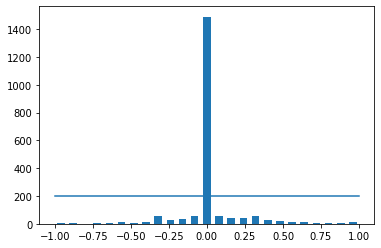

In [6]:
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

Data Balancing

total data: 2027
removed: 0
removed: 0
removed: 0
removed: 0
removed: 0
removed: 0
removed: 0
removed: 0
removed: 0
removed: 0
removed: 0
removed: 0
removed: 1289
removed: 1289
removed: 1289
removed: 1289
removed: 1289
removed: 1289
removed: 1289
removed: 1289
removed: 1289
removed: 1289
removed: 1289
removed: 1289
removed: 1289
remaining: 738


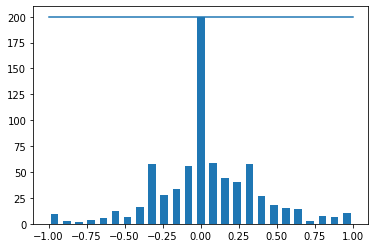

In [7]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

  print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [0]:
def load_img_steering(datadir , df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

In [9]:
print(data.iloc[2])

center      center_2020_02_07_15_47_48_661.jpg
left        left_2020_02_07_15_47_48_661.jpg  
right       right_2020_02_07_15_47_48_661.jpg 
steering    0                                 
throttle    0                                 
reverse     0                                 
speed       7.85271e-05                       
Name: 7, dtype: object


Training Samples: 590
Valid Samples: 148


Text(0.5, 1.0, 'Validation set')

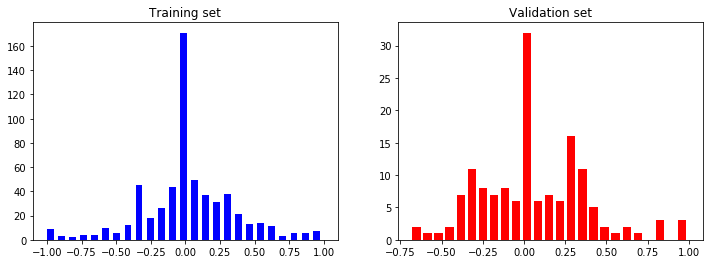

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [0]:
def img_preprocess(img):
  img = mpimg.imread(img)
  img = img[60:135,:,:]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img,  (3, 3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img

Text(0.5, 1, 'Preprocessed Image')

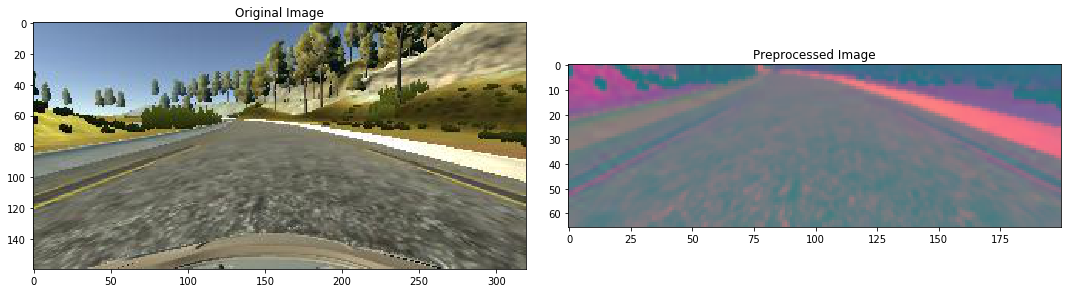

In [12]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [0]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_valid = np.array(list(map(img_preprocess, X_valid)))


(590, 66, 200, 3)


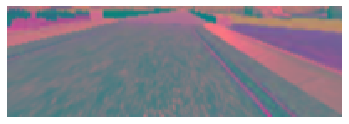

In [17]:
plt.imshow(X_train[random.randint(0, len(X_train)-1)])
plt.axis('off')
print(X_train.shape)

In [0]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, 5, 5, subsample=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(64, 3, 3, activation='elu')) 
  model.add(Convolution2D(64, 3, 3, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Flatten()) 
  model.add(Dense(100, activation = 'elu'))
  model.add(Dropout(0.5))

  model.add(Dense(50, activation = 'elu'))
  model.add(Dense(10, activation = 'elu'))
  model.add(Dense(1))

  optimizer = Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model

In [29]:
model = nvidia_model()
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_13 (Dropout)         (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 1152)             

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), act

In [32]:
history = model.fit(X_train,y_train,epochs=30,validation_data=(X_valid,y_valid),batch_size=100,verbose = 1,shuffle = 1)




Train on 590 samples, validate on 148 samples
Epoch 1/30





590/590 [==============================] - 7s 11ms/step - loss: 1.0768 - val_loss: 0.1101
Epoch 2/30
590/590 [==============================] - 4s 8ms/step - loss: 0.2810 - val_loss: 0.1402
Epoch 3/30
590/590 [==============================] - 4s 8ms/step - loss: 0.2119 - val_loss: 0.1070
Epoch 4/30
590/590 [==============================] - 4s 8ms/step - loss: 0.1534 - val_loss: 0.1081
Epoch 5/30
590/590 [==============================] - 4s 8ms/step - loss: 0.1373 - val_loss: 0.1088
Epoch 6/30
590/590 [==============================] - 4s 8ms/step - loss: 0.1398 - val_loss: 0.1111
Epoch 7/30
590/590 [==============================] - 4s 8ms/step - loss: 0.1347 - val_loss: 0.1041
Epoch 8/30
590/590 [==============================] - 4s 8ms/step - loss: 0.1206 - val_loss: 0.1002
Epoch 9/30
590/590 [==============================] - 5s 8ms/step - loss: 0.1245 - val_loss: 0.1062
Epoch 10/30
590/590 [========================

Text(0.5, 0, 'Epoch')

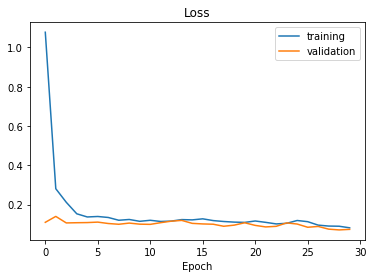

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [0]:
model.save('model.h5')

In [0]:
from google.colab import files
files.download('model.h5')